In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import datetime as dt
import json

## 퀀트함수
from quant_functions import anal_funcs, data_funcs
import portfolio_obtimizer
import myfuncs
from fredapi import Fred
fred = Fred(api_key='cfb4f49f5c1a9396f671b8049d992e56')

# 시각화 관련
import plotly_express as px
import plotly.figure_factory as ff
import cufflinks as cf
cf.go_offline(connected=True)
## cf.getThemes()
cf.set_config_file(theme='polar')
import plotly.graph_objects as go
import seaborn as sns
sns.set_style('whitegrid')
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as mticker
from matplotlib.ticker import LogLocator
import matplotlib.pyplot as plt
## figure size 설정
figsize=(12, 8)
plt.rcParams["figure.figsize"] = figsize
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline

import graphModule as gm

## color 설정
with open('colors.json') as f:
    mycolors = json.load(f)

# 블루 테마
cmap_colors = ["#FFFFFF", mycolors['color_cont3'], mycolors['color_cont2']]
# LinearSegmentedColormap 생성
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", cmap_colors, N=256)    

## shock case
with open('shockCase.json', encoding='utf-8') as f:
    shock_cases = json.load(f)

## Data Load

In [2]:
## 보간용 필수 데이터
gold = pd.read_csv(f"gold.csv", encoding='utf-8').set_index('Date')[['Close']].rename(columns={'Close':'Gold'})
gold.index = pd.to_datetime(gold.index)
ds20 = fred.get_series('DGS20')
ds10 = fred.get_series('DGS10')

## load data
df_ref = data_funcs.get_merged_df('^IXIC', '^GSPC', '^DJI', 'GC=F')
df_ref = df_ref.fillna(method = 'pad')
df_ref['Gold'] = gold['Gold']
df_ref['DGS10'] = ds10
df_ref['DGS20'] = ds20

## Imputation
df_ref = myfuncs.imputation(df_ref, '^GSPC', '^DJI')
df_ref = myfuncs.imputation(df_ref, 'DGS10', 'DGS20')
df_ref = myfuncs.imputation(df_ref, 'DGS20', 'DGS10')
df_ref = myfuncs.imputation(df_ref, 'GC=F', 'Gold')
df_ref['Gold']['1975-01-02'] = 1
df_ref['Gold']['1975-01-03'] = 1

## column selection
df_ref = df_ref[['^GSPC', '^DJI', '^IXIC', 'DGS10', 'DGS20', 'Gold']]
df_ref.columns = ['S&P500', 'DowJones', 'NASDAQ', 'DGS10', 'DGS20', 'Gold']

## 75년 이전에는 Gold 데이터가 없음
df_ref = df_ref['1975':]
df_ref = df_ref/df_ref.iloc[0]

[*********************100%%**********************]  4 of 4 completed

0.9189496391200421
0.7566404456387097
1.1913266598764871
0.9953424146502147


In [3]:
## 프로젝트마다 필요한 데이터
tickers = ['QQQ', 'TLT']
df_ori = data_funcs.get_merged_df(*tickers)
df_ori = df_ori[tickers]

[*********************100%%**********************]  2 of 2 completed


In [4]:
## 보간 시계열 데이터
df_imp = pd.concat([df_ref, df_ori], axis=1)
df_imp = myfuncs.imputation(df_imp, 'NASDAQ', 'QQQ')
df_imp = myfuncs.imputation(df_imp, 'DGS20', 'TLT')

## 비보간 시계열 데이터
df_cut = df_ori.dropna()
df_cut = df_cut/df_cut.iloc[0]

1.044926175731185
-0.41920941513643656


In [5]:
highlight_periods = [(shock_cases['1차오일쇼크_t0'], shock_cases['1차오일쇼크_t1']),
                     (shock_cases['2차오일쇼크_t0'], shock_cases['2차오일쇼크_t1']),
                     (shock_cases['물가충격_t0'], shock_cases['물가충격_t1']),
                     (shock_cases['걸프전_t0'], shock_cases['걸프전_t1']),
                     (shock_cases['닷컴버블_t0'], shock_cases['닷컴버블_t1']),
                     (shock_cases['금융위기_t0'], shock_cases['금융위기_t1']),
                     (shock_cases['코로나_t0'], shock_cases['코로나_t1'])]

## Visualization

In [6]:
## assets = ['JEPQ', 'QQQ']
assets = ['QQQ', 'TLT', 'Gold']

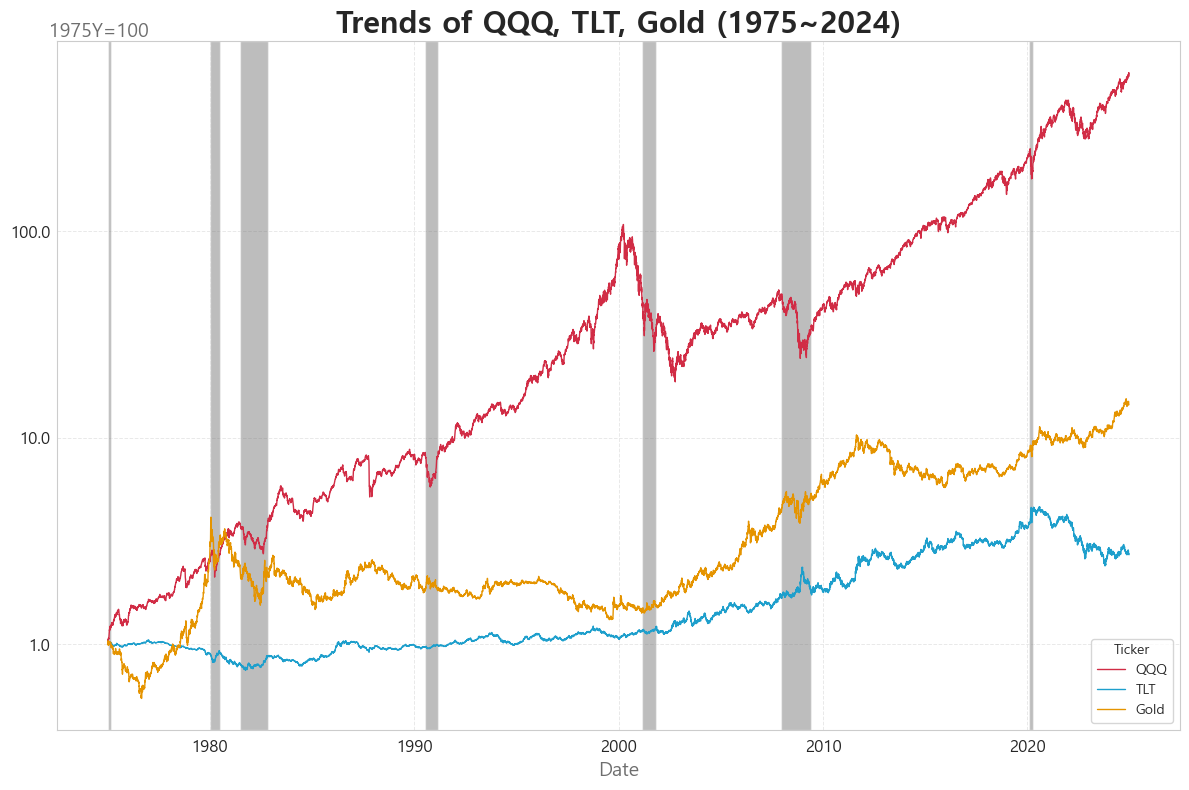

In [7]:
gm.trend_plot(df_imp, assets, highlight_periods=highlight_periods, colors=[mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub']])

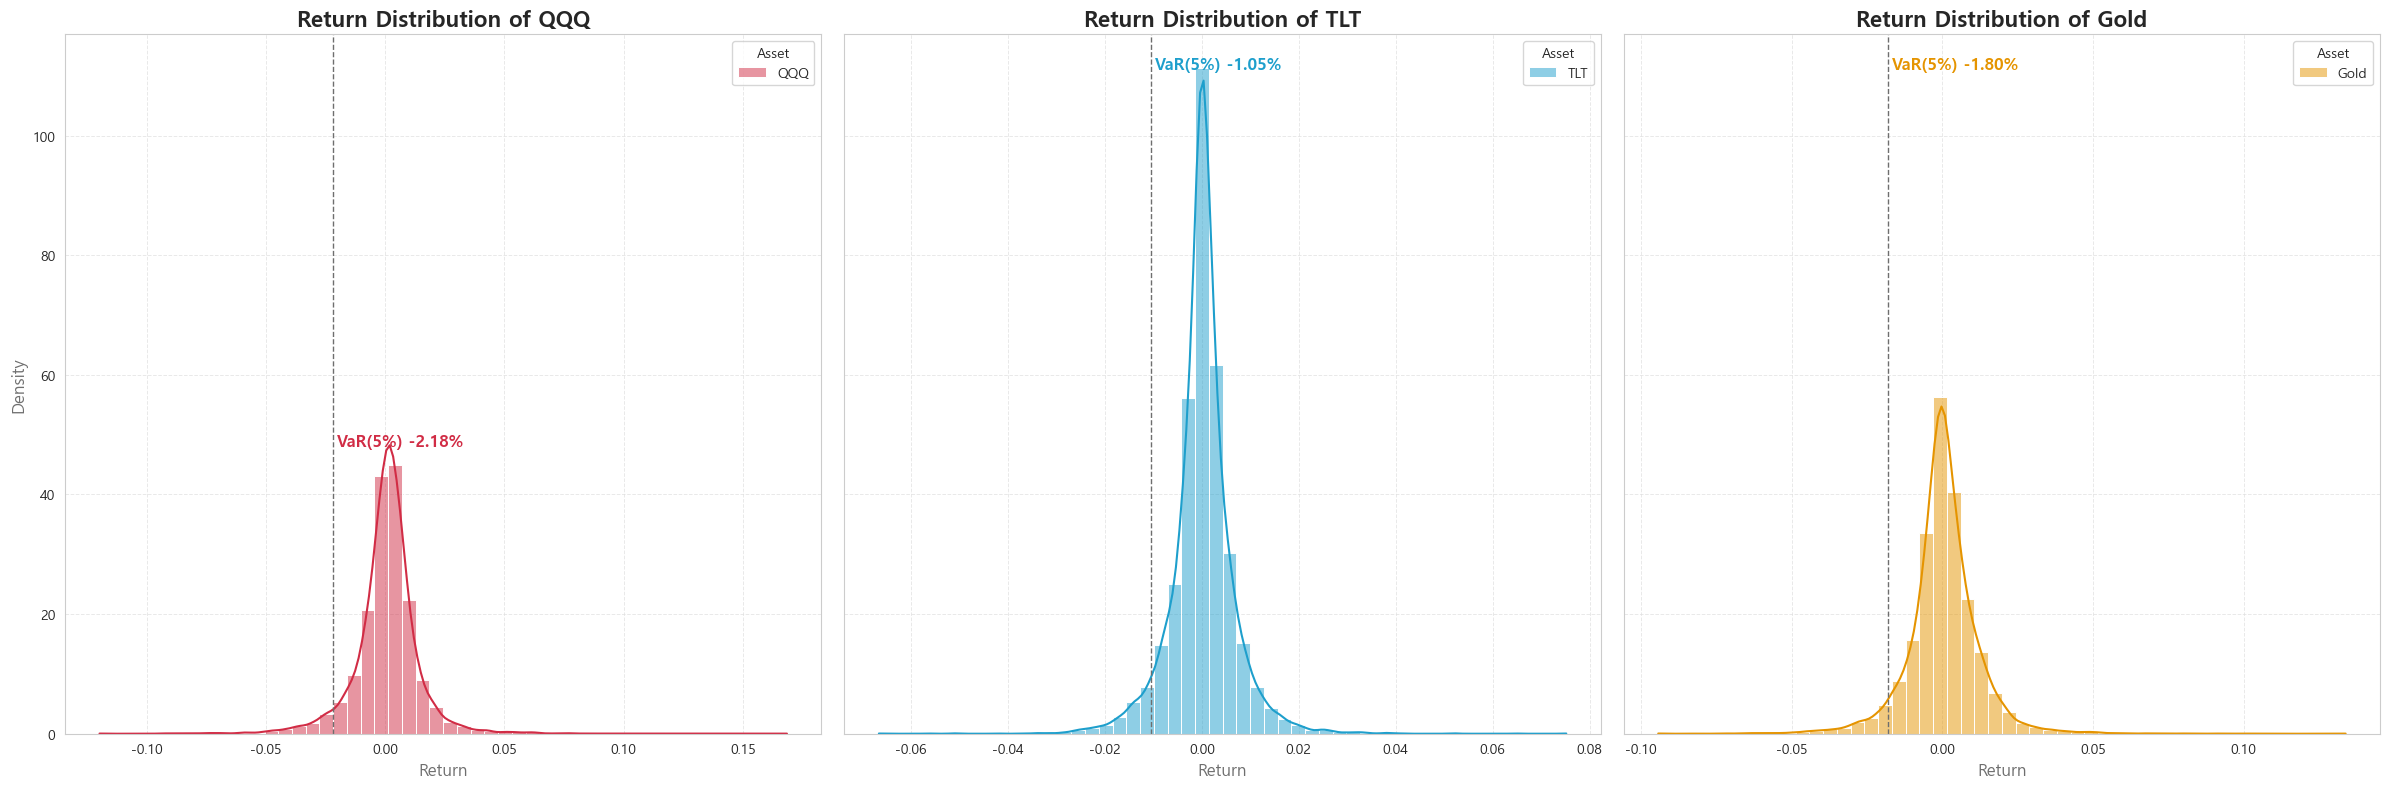

In [8]:
gm.asset_histogram_plot(df_imp.pct_change(), assets, colors=[mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub']])

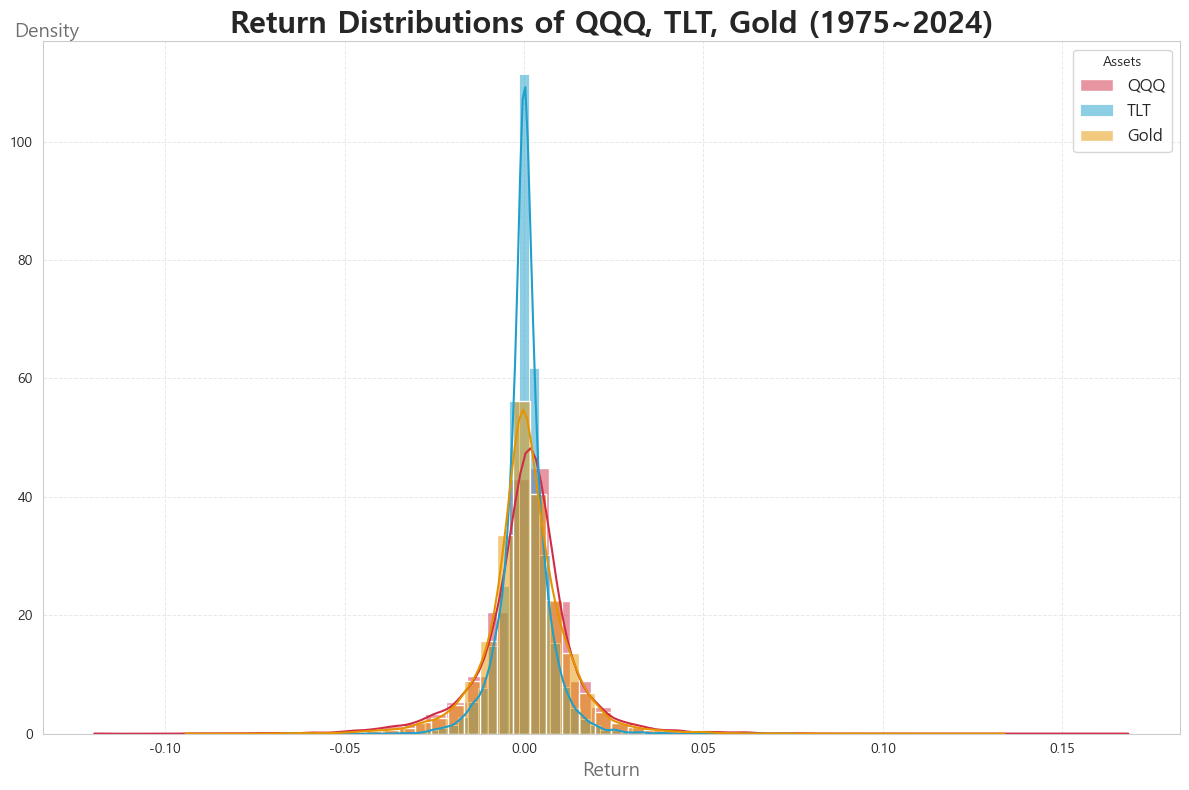

In [9]:
gm.asset_histogram_merged_plot(df_imp.pct_change(), assets, colors=[mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub']])

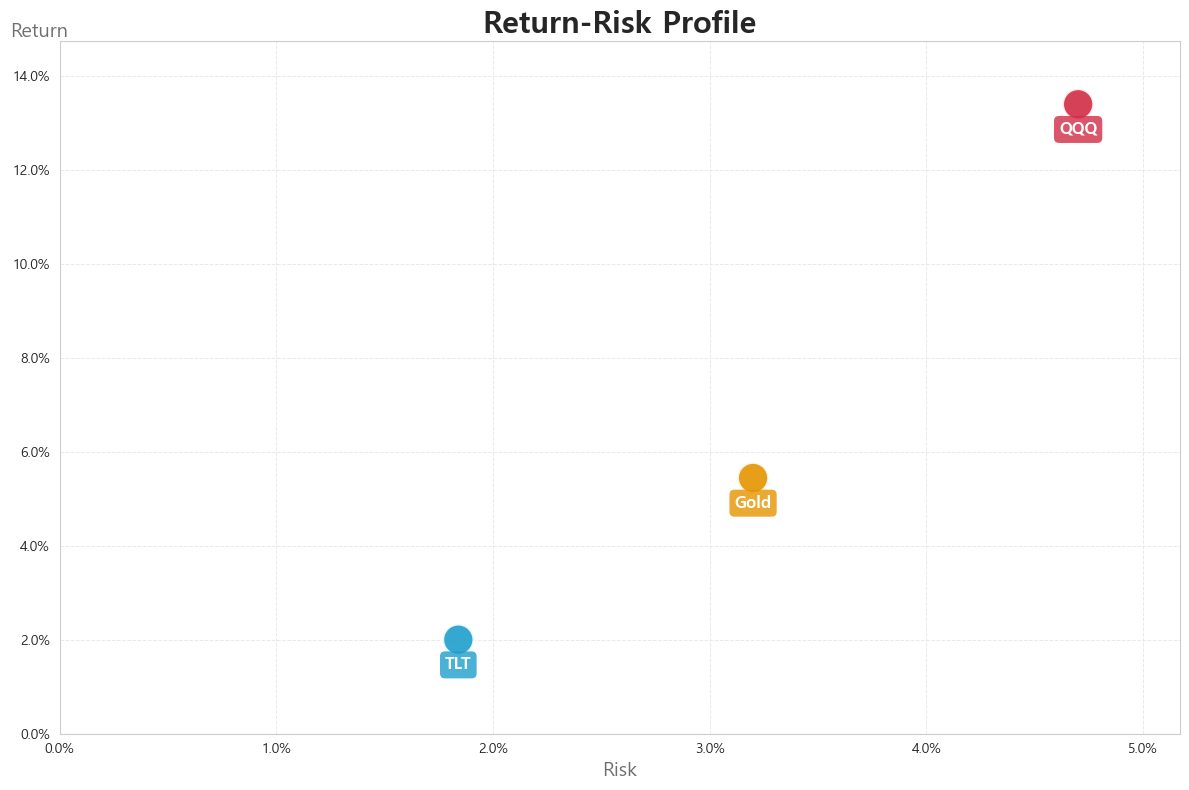

In [10]:
return_risk_df = anal_funcs.get_Vol_report(df_imp[assets], method='a', rf=0)
gm.return_risk_profile_plot(return_risk_df, assets, colors=[mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub']])

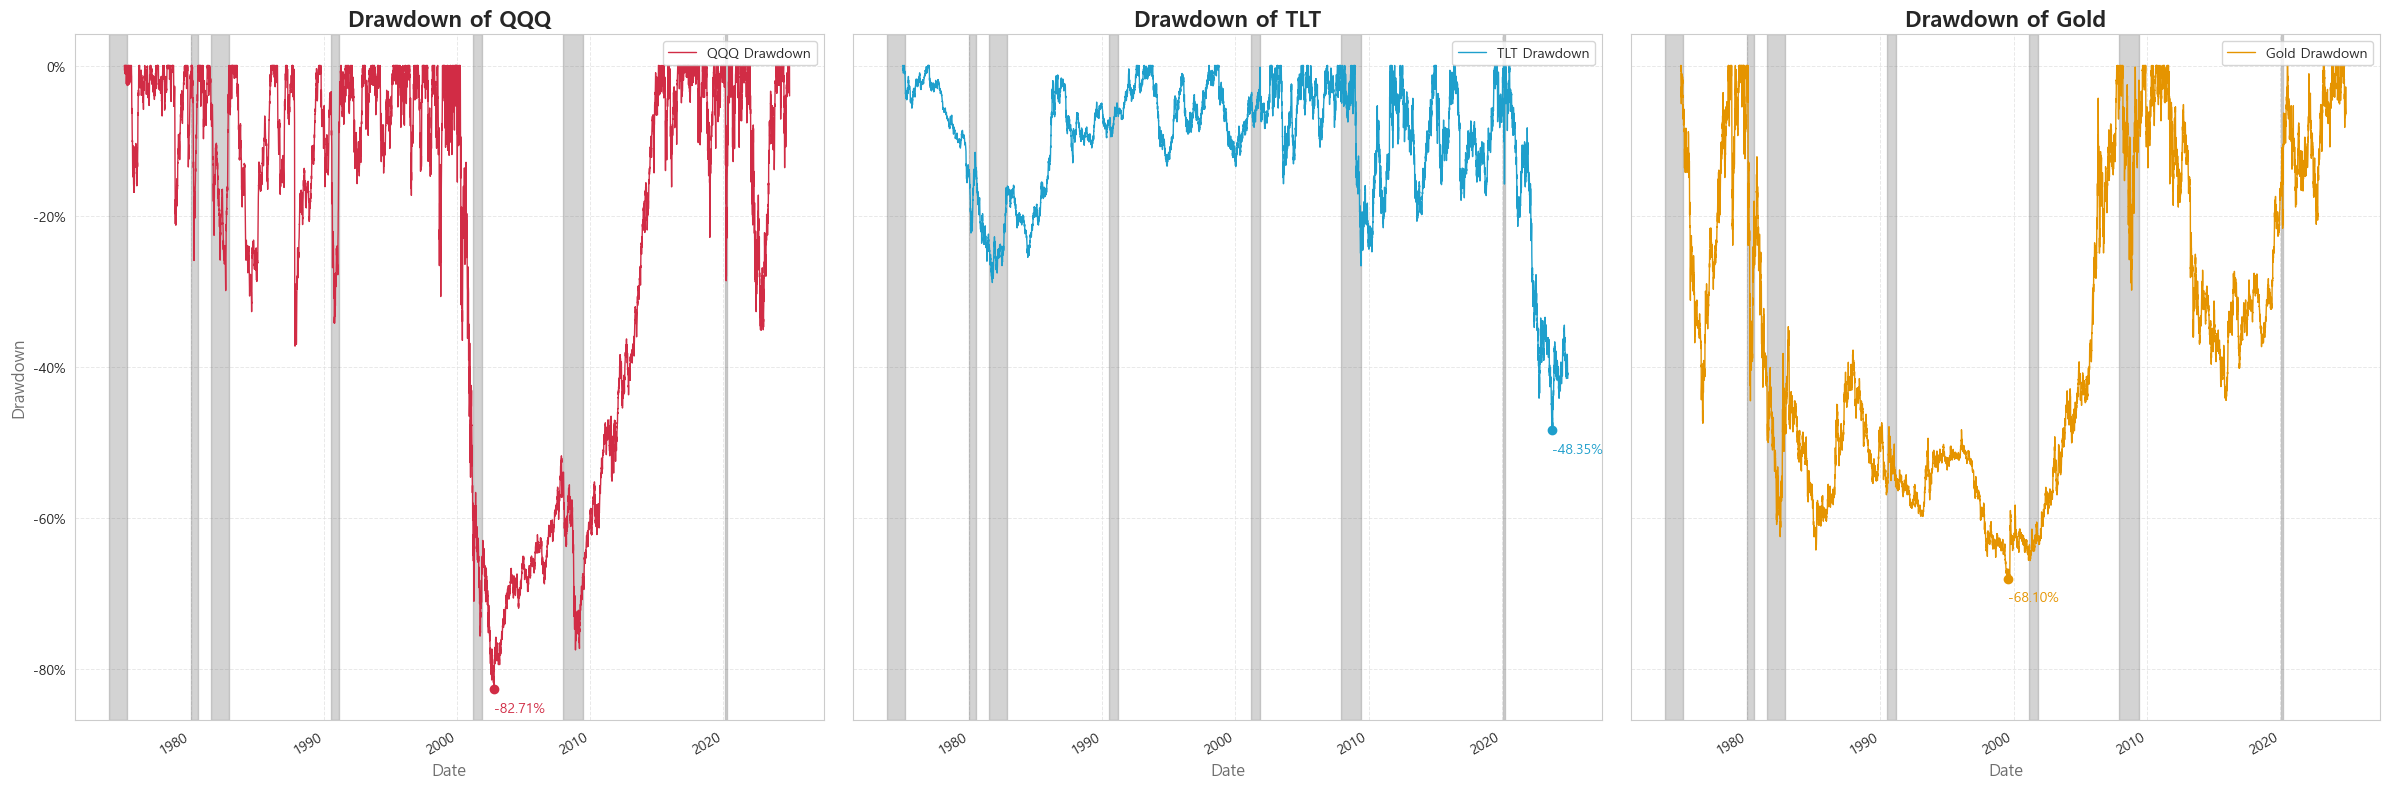

In [11]:
gm.drawdown_plot(df_imp, assets, colors=[mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub']])

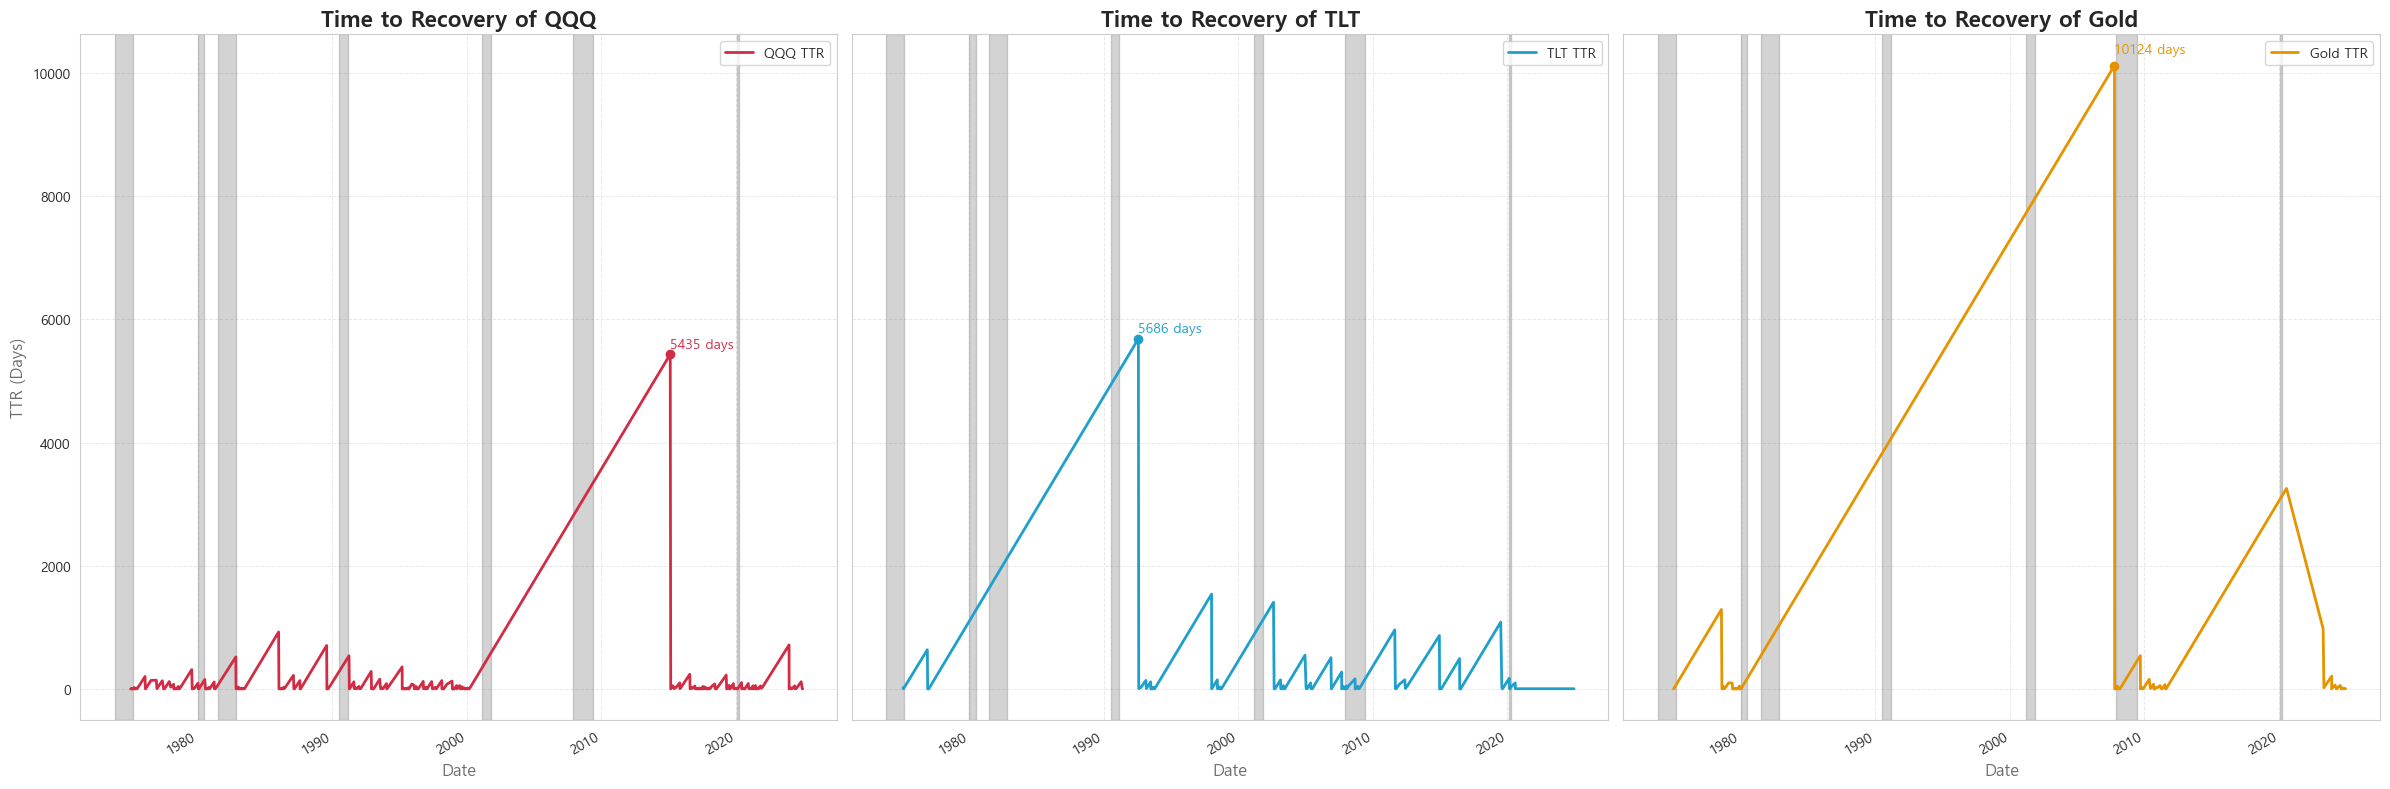

In [12]:
ttr_df = myfuncs.get_ttr_df(df_imp, assets)
gm.ttr_plot(ttr_df, assets, highlight_periods=highlight_periods, colors=[mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub']])

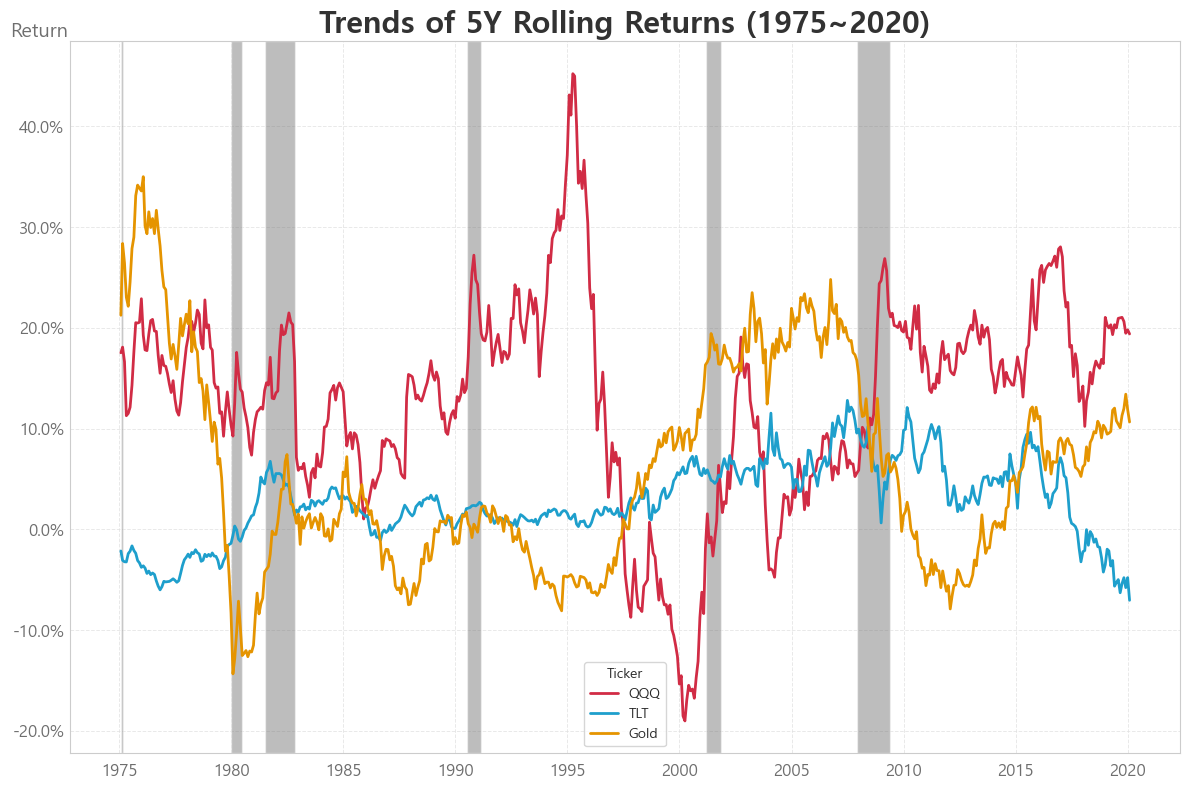

In [13]:
rr_df = myfuncs.get_rr_df(df_imp, assets)
gm.rr_trend_plot(rr_df, assets, highlight_periods=highlight_periods, colors=[mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub']])

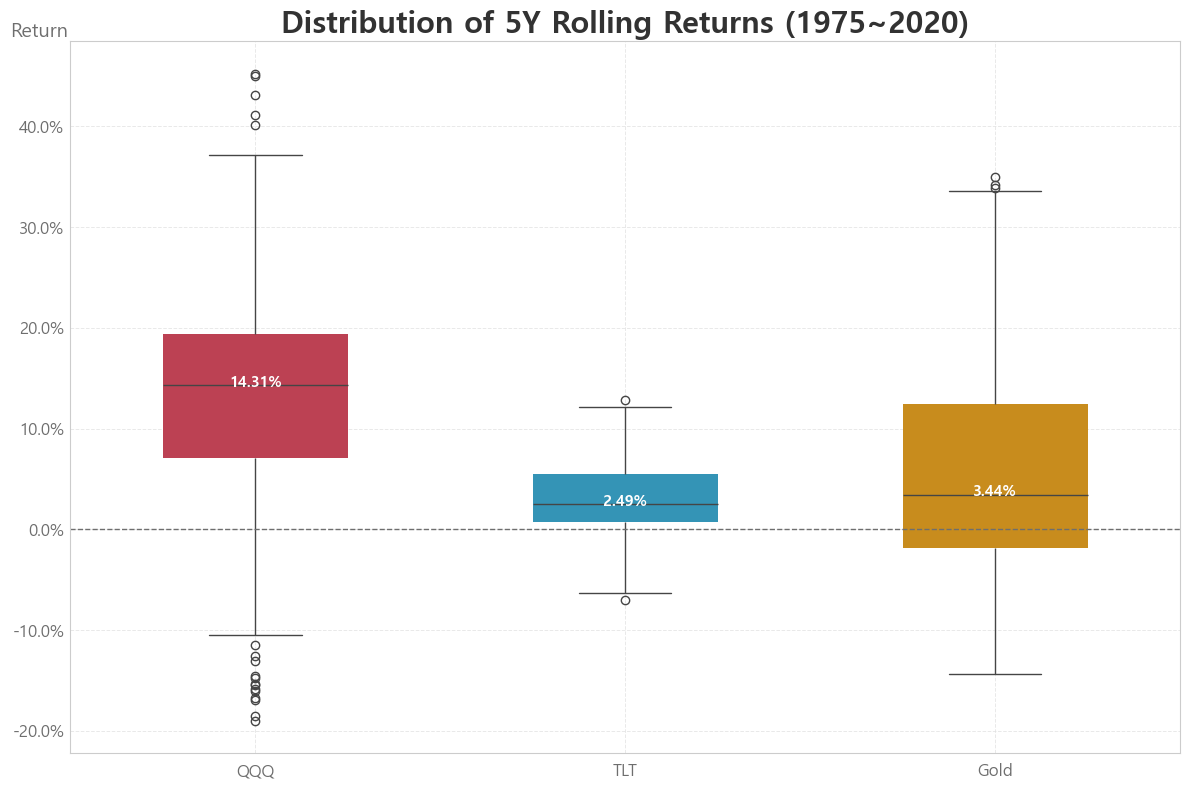

In [14]:
gm.rr_box_plot(rr_df, assets, colors=[mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub']])

In [15]:
corr_df = df_imp.pct_change()[['NASDAQ', 'QQQ', 'S&P500', 'DowJones', 'DGS10', 'DGS20', 'Gold']].corr()

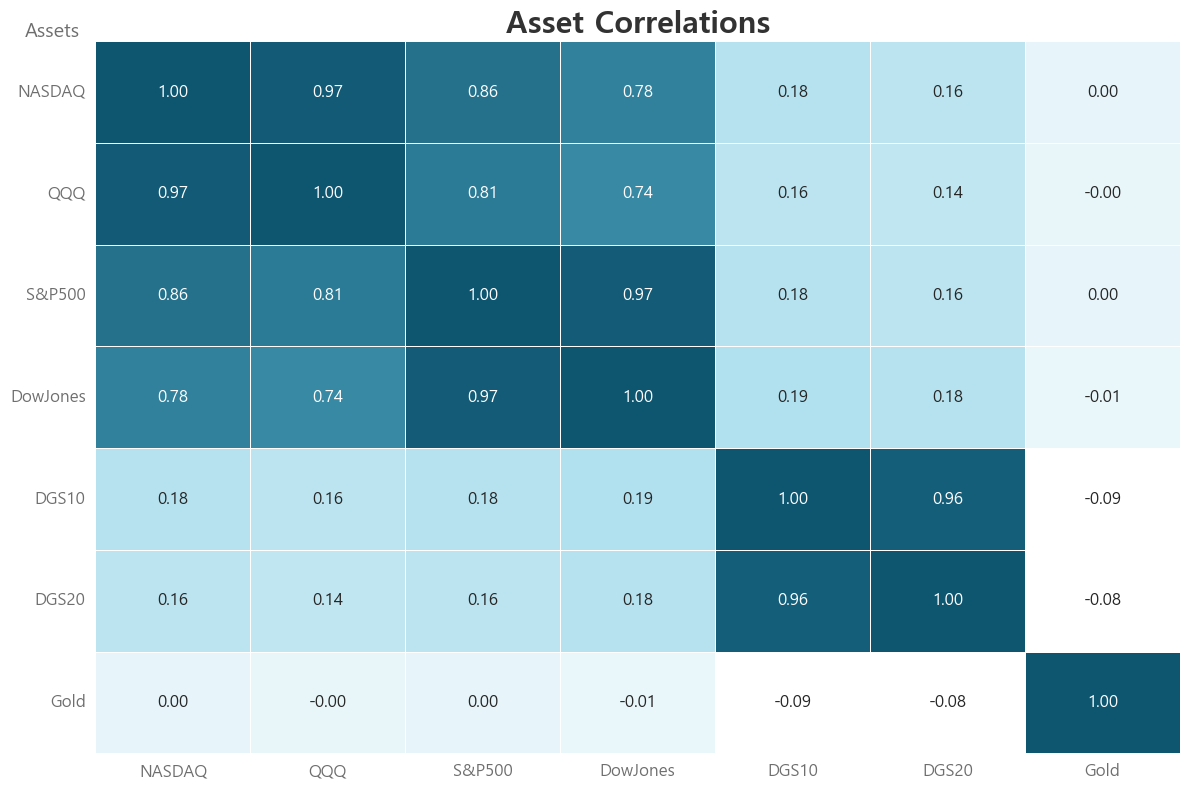

In [16]:
gm.corr_plot(corr_df, cmap=custom_cmap)

## Optimization

In [17]:
df_imp_m = df_imp[assets].resample('M').last()

In [18]:
allocator = portfolio_obtimizer.PortfolioAllocator()

cal_optimal => eg. process, obtimal, min_risk = cal_optimal(df)
eg. process, obtimal, min_risk = cal_optimal(df)


In [19]:
process, obtimal, min_risk = allocator.cal_optimal(df_imp_m, unit='monthly', rebalancing='m', d=5, min_edge=0)

총 231번 시행 예정
1번째 시행 중
100번째 시행 중
200번째 시행 중


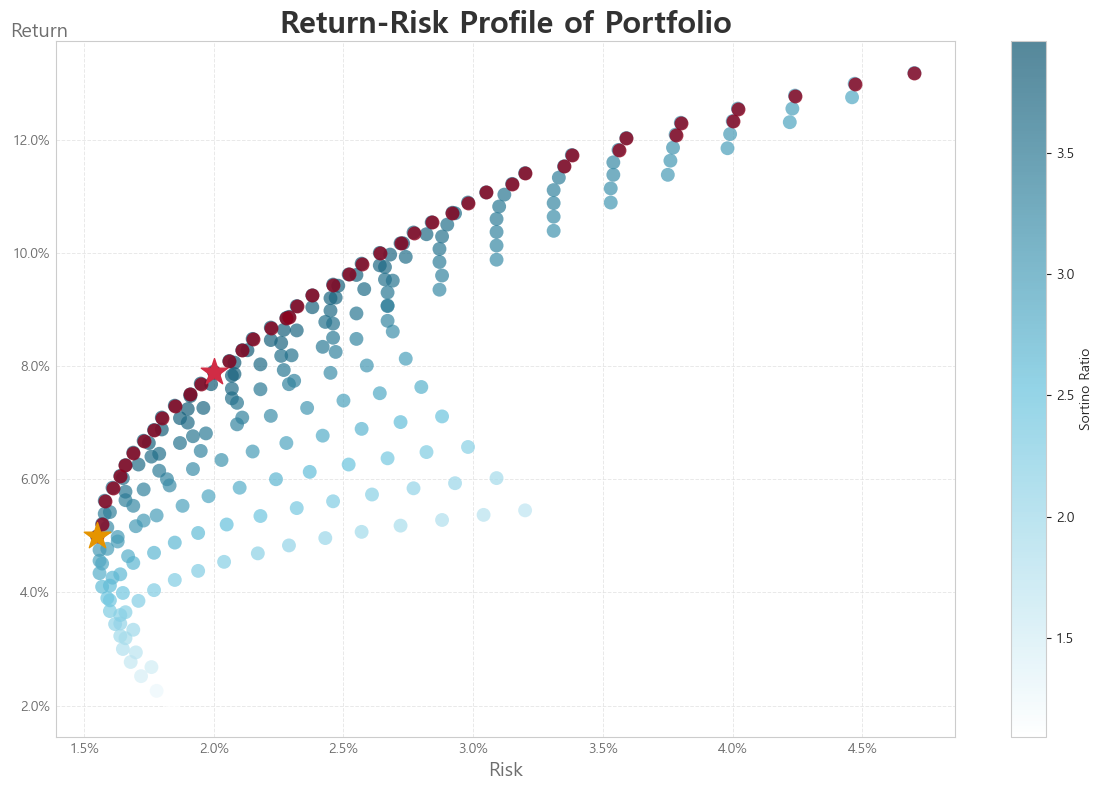

In [20]:
gm.portfilio_return_risk_profile_plot(process, obtimal, min_risk, cmap=custom_cmap)

In [21]:
process[process['Point'] == 'Obtimal']

,QQQ,TLT,Gold,Return,Volatility,Volatility(Down),Sharpe Ratio,Sortino Ratio,Point,Efficient
133,0.35,0.35,0.3,7.9,2.99,2.0,2.64,3.96,Obtimal,True


In [22]:
## ratio 임의 조정시
ratio = [0.35, 0.35, 0.3]
result = allocator.cal_rebalancing(df_imp_m, ratio=ratio, rebalancing='m', unit='monthly')
result.rename(columns={'strategy':'Portfolio'}, inplace=True)
result = result/result.iloc[0]*100

In [23]:
port_ssets = ['Portfolio', 'QQQ', 'TLT', 'Gold']
port_ssets_sp = ['Portfolio', 'QQQ']

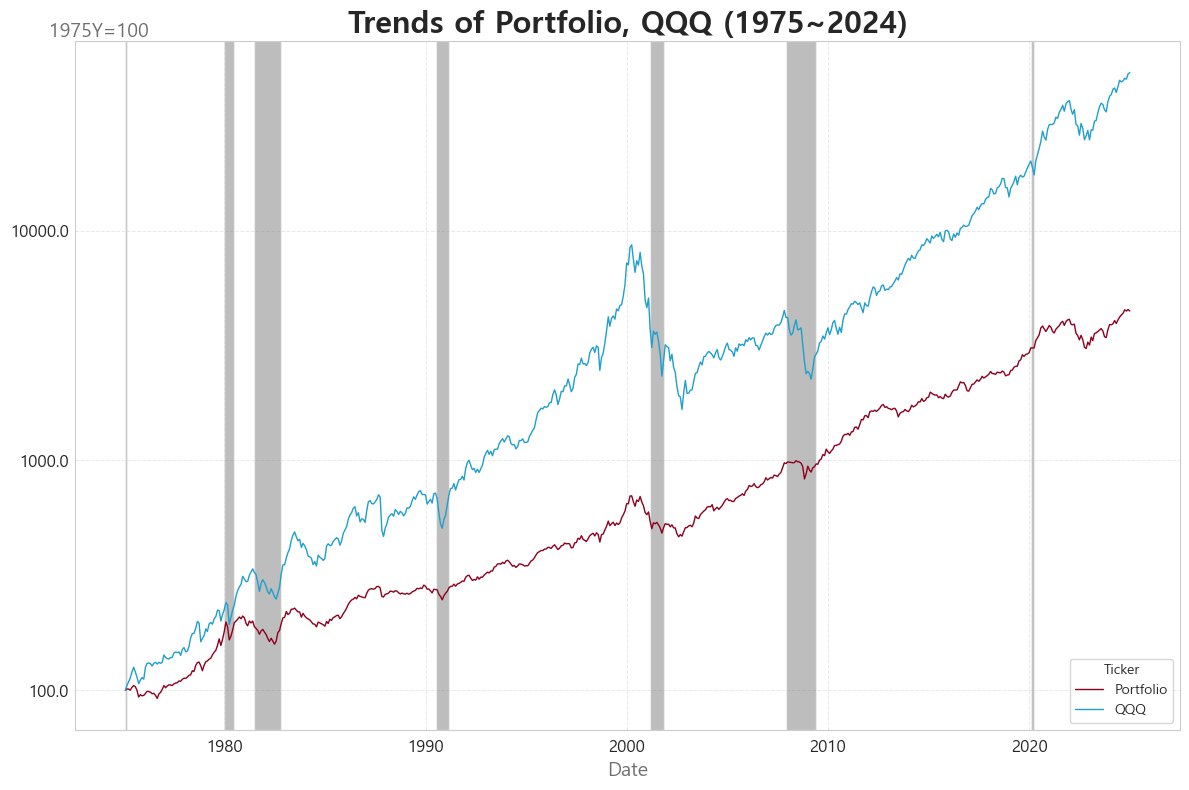

In [24]:
gm.trend_plot(result, port_ssets_sp, highlight_periods=highlight_periods, colors=[mycolors['color_norm2'], mycolors['color_cont']])

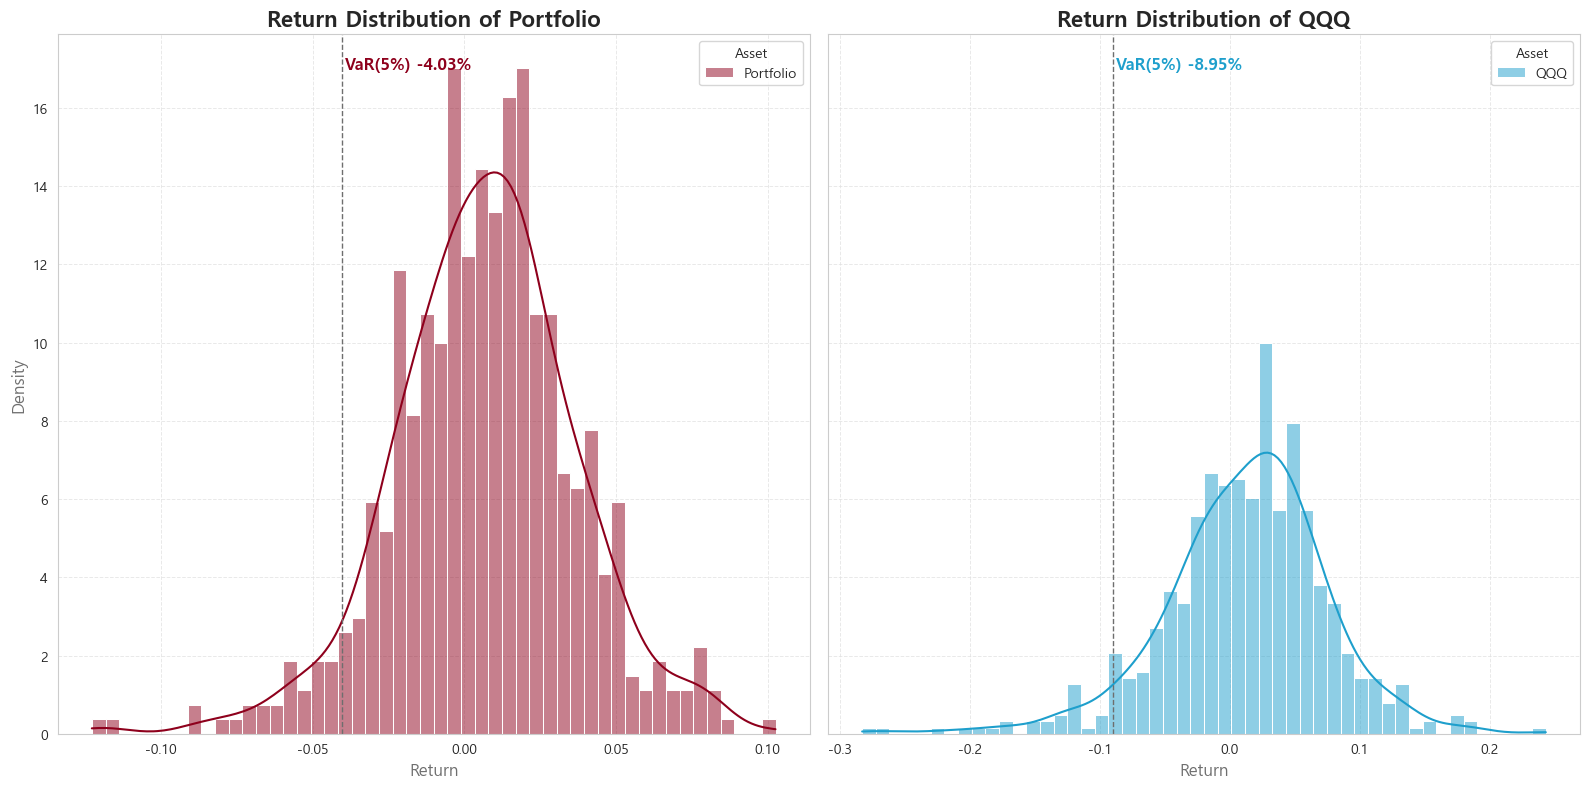

In [25]:
gm.asset_histogram_plot(result.pct_change(), port_ssets_sp, colors=[mycolors['color_norm2'], mycolors['color_cont']])

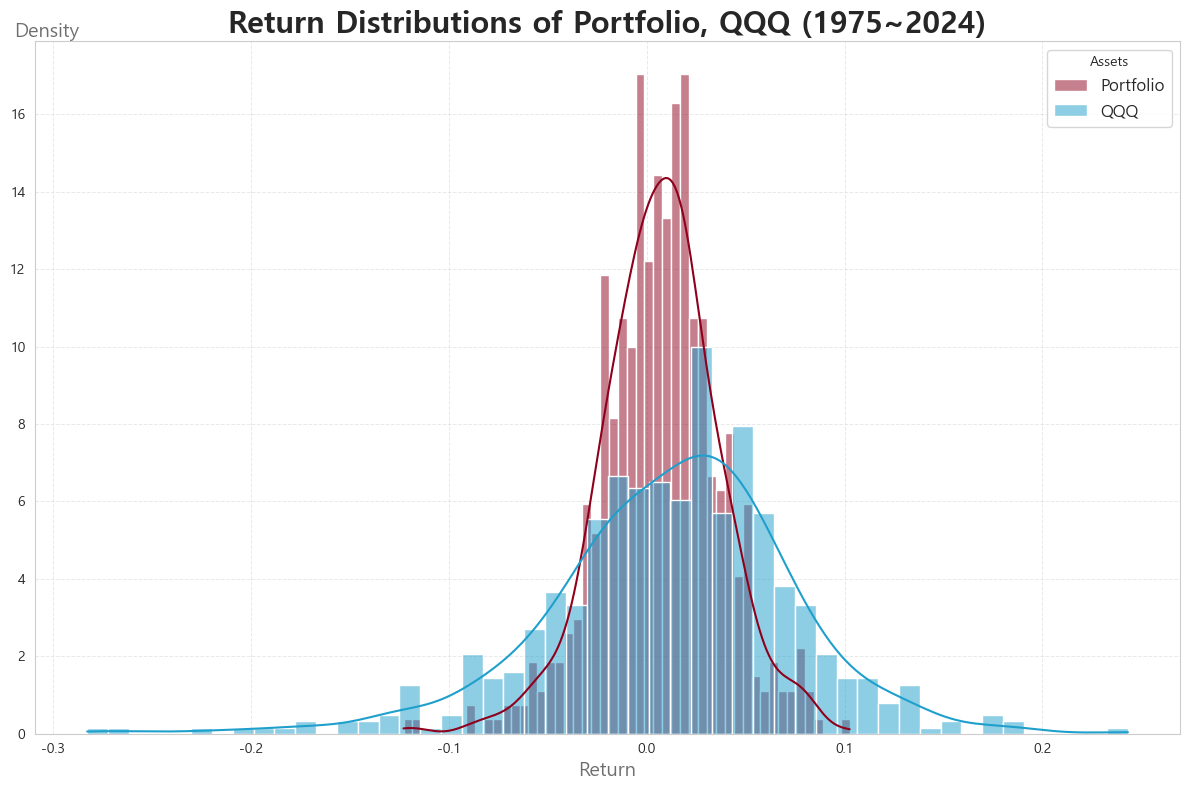

In [26]:
gm.asset_histogram_merged_plot(result.pct_change(), port_ssets_sp, colors=[mycolors['color_norm2'], mycolors['color_cont']])

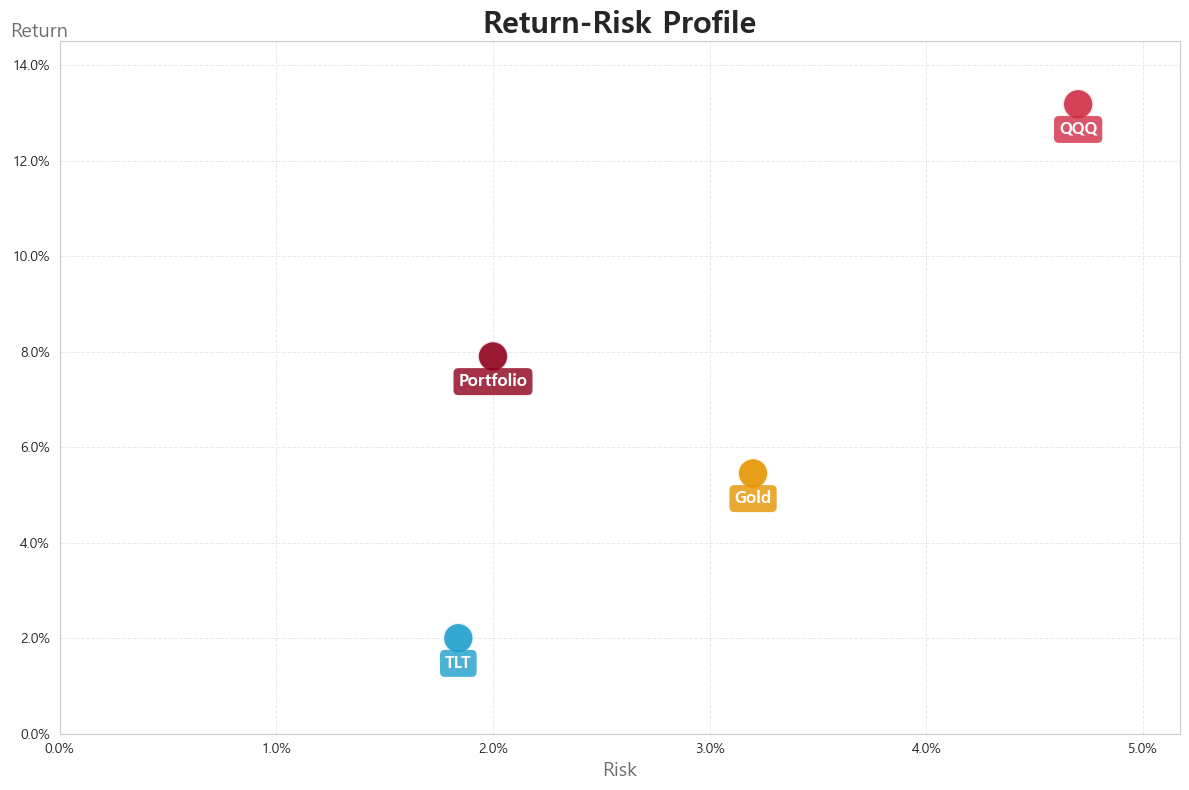

In [27]:
return_risk_df = anal_funcs.get_Vol_report(result[port_ssets], unit='monthly', method='a', rf=0)
gm.return_risk_profile_plot(return_risk_df, port_ssets, colors=[mycolors['color_norm2'], mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub']])

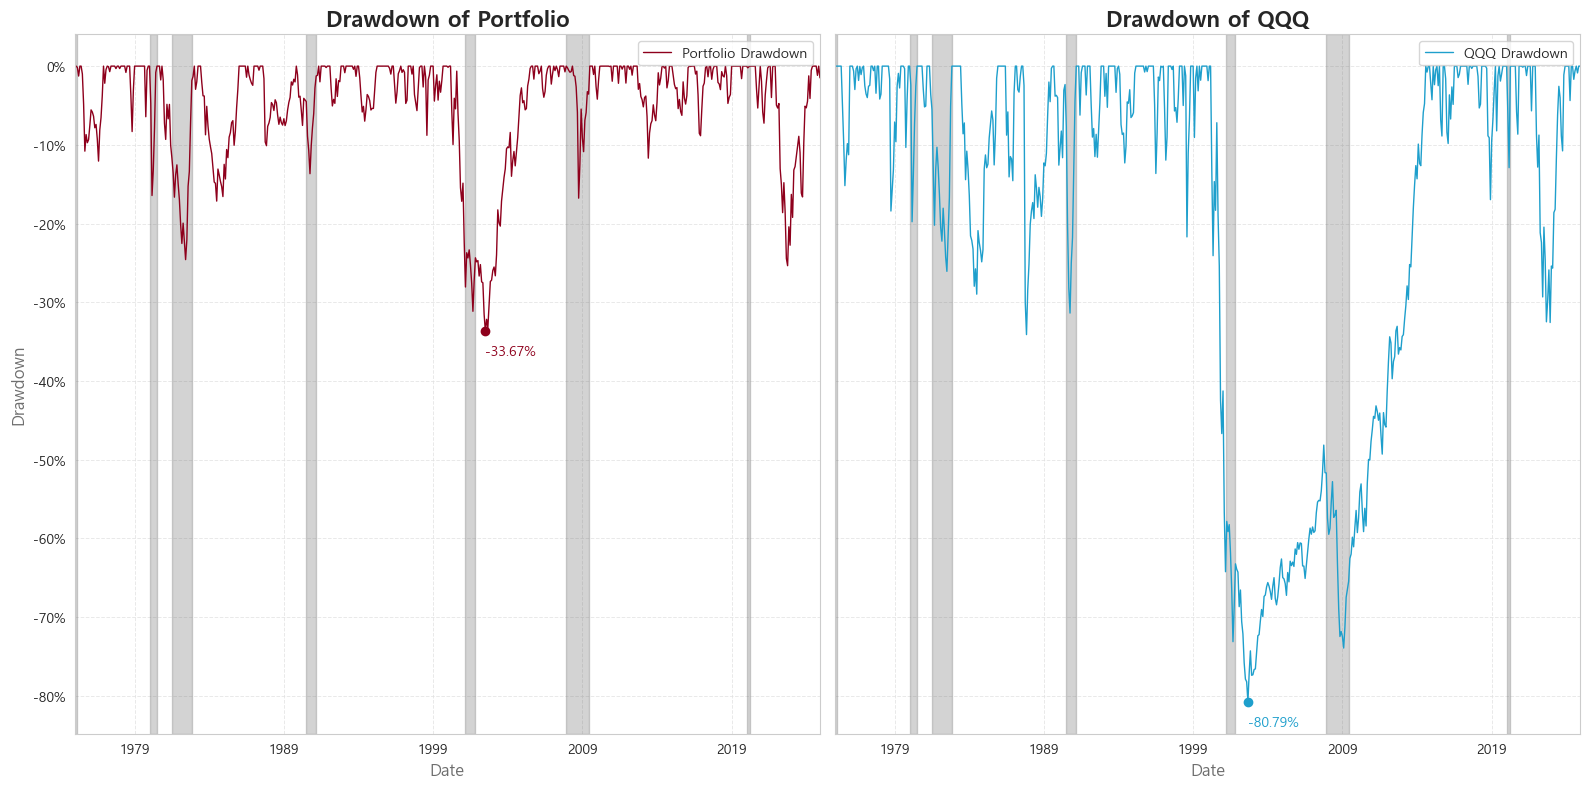

In [28]:
gm.drawdown_plot(result, port_ssets_sp, colors=[mycolors['color_norm2'], mycolors['color_cont']])

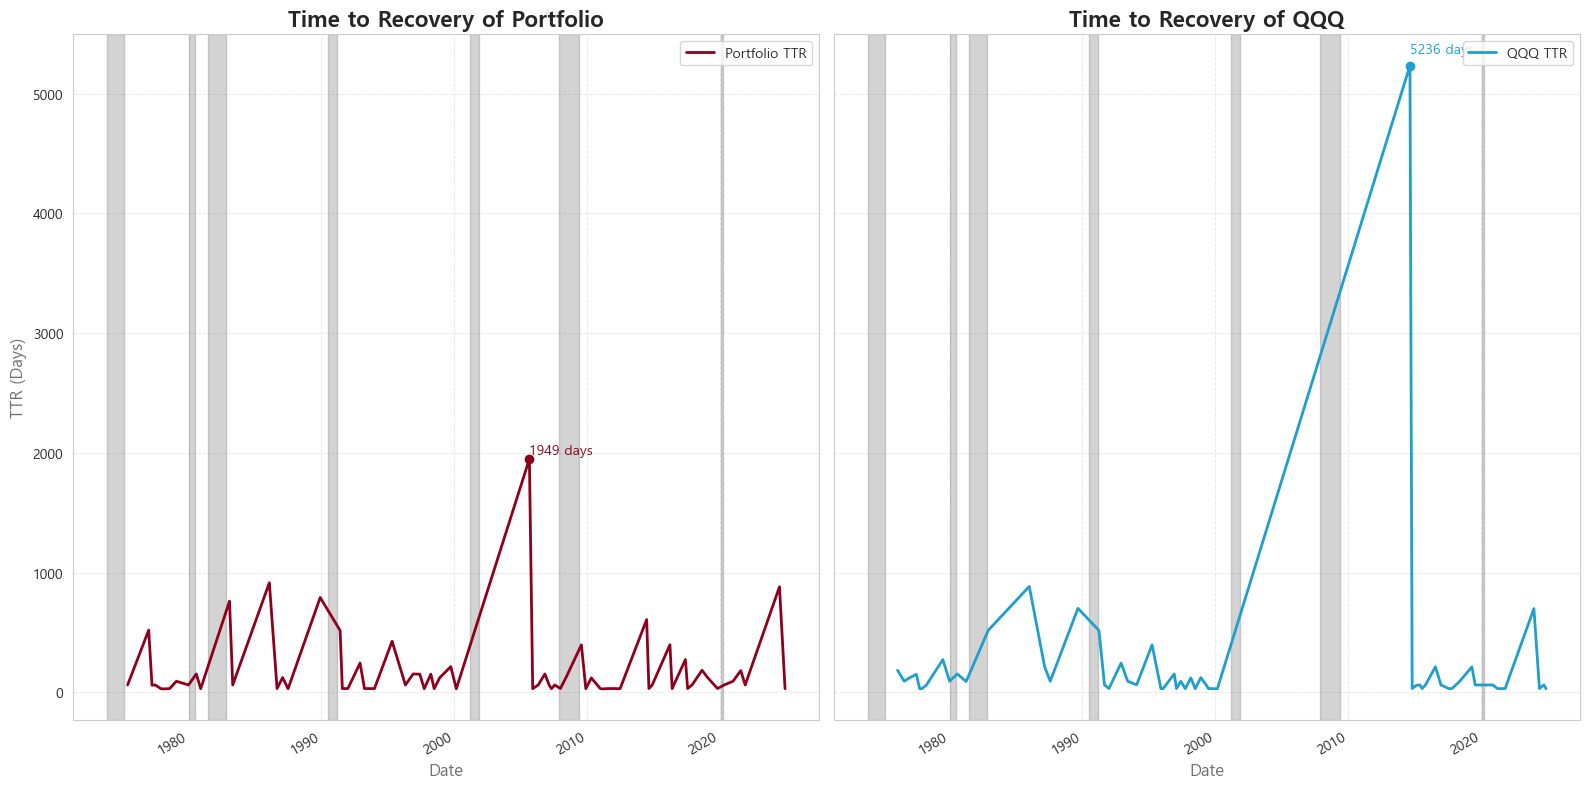

In [29]:
ttr_df = myfuncs.get_ttr_df(result, port_ssets_sp)
gm.ttr_plot(ttr_df, port_ssets_sp, highlight_periods=highlight_periods, colors=[mycolors['color_norm2'], mycolors['color_cont']])

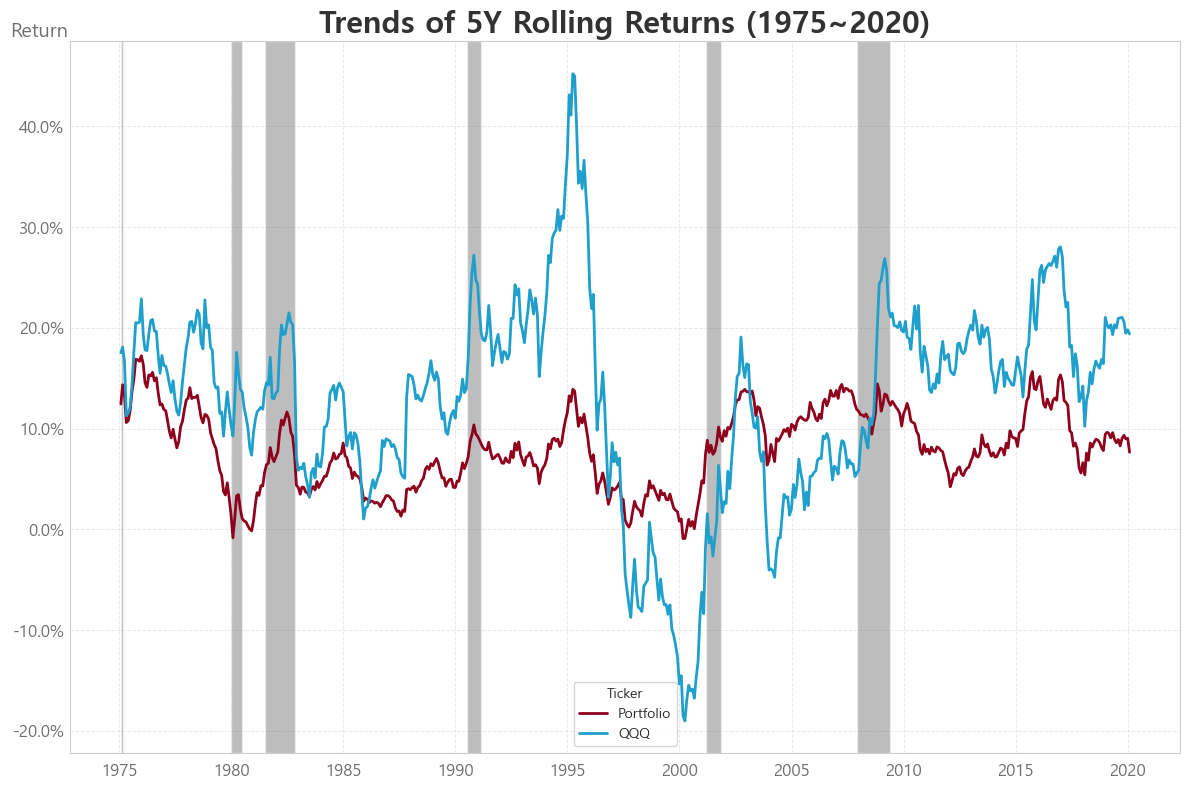

In [30]:
rr_df = myfuncs.get_rr_df(result, port_ssets_sp)
gm.rr_trend_plot(rr_df, port_ssets_sp, highlight_periods=highlight_periods, colors=[mycolors['color_norm2'], mycolors['color_cont']])

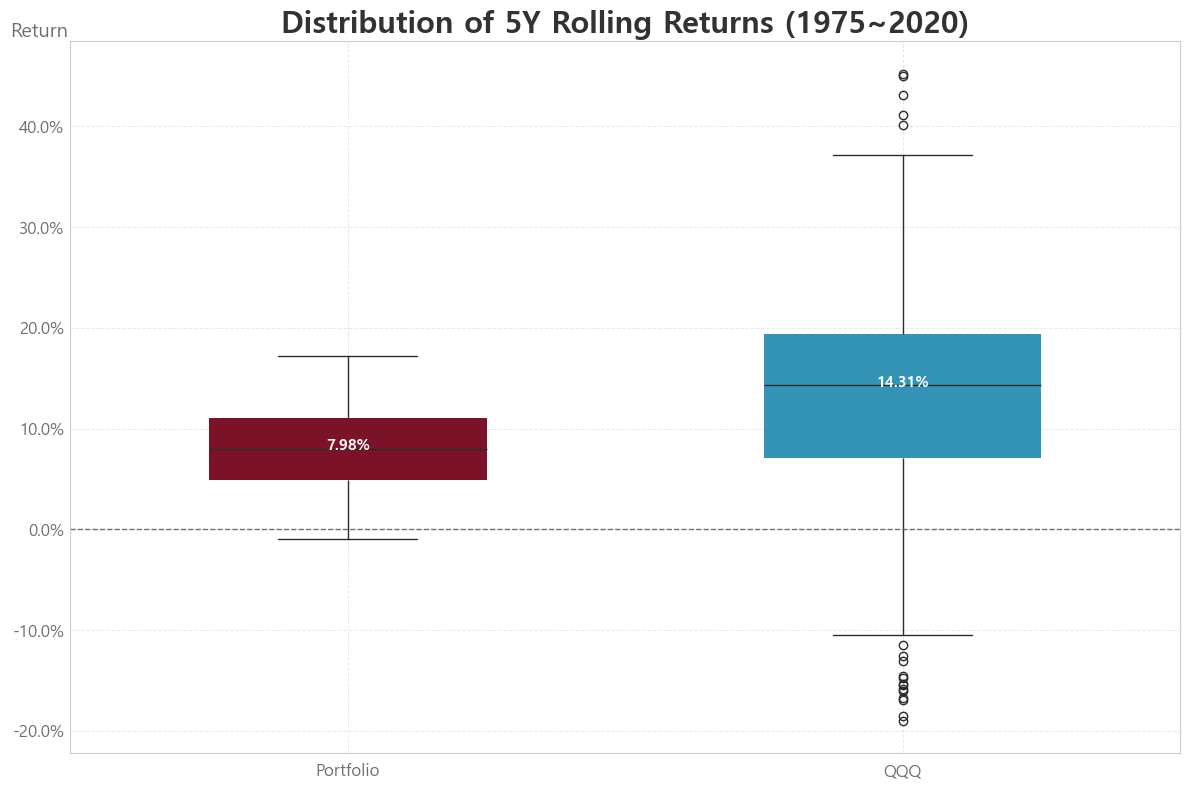

In [31]:
gm.rr_box_plot(rr_df, port_ssets_sp, colors=[mycolors['color_norm2'], mycolors['color_cont']])